In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
bilstm_model = create_bilstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

bilstm_history = bilstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
bilstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = bilstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 12:30:03.649680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.834044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.836136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 12:30:04.586480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-26 12:30:10.780664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-26 12:30:10.992149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor 

Epoch 1/10


2023-03-26 12:30:11.104295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 12:30:11.143221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:11.144335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

479/479 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8096

2023-03-26 12:30:49.842108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:49.843227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:30:49.844450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 40s 78ms/step - loss: 0.5208 - accuracy: 0.8096 - val_loss: 0.3841 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 36s 75ms/step - loss: 0.2436 - accuracy: 0.9137 - val_loss: 0.3433 - val_accuracy: 0.8793
Epoch 3/10
479/479 [==============================] - 36s 76ms/step - loss: 0.1902 - accuracy: 0.9353 - val_loss: 0.3473 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1563 - accuracy: 0.9449 - val_loss: 0.3648 - val_accuracy: 0.8850
Epoch 5/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1378 - accuracy: 0.9536 - val_loss: 0.3734 - val_accuracy: 0.8884
Epoch 6/10
479/479 [==============================] - 38s 78ms/step - loss: 0.1271 - accuracy: 0.9589 - val_loss: 0.3625 - val_accuracy: 0.8938
Epoch 7/10
479/479 [==============================] - 38s 79ms/step - loss: 0.1076 - accuracy: 0.9647 - val_loss: 0.3791 - val_accuracy: 0.8922
Epo

2023-03-26 12:36:27.426154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:36:27.427301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:36:27.428272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       501
           1       0.89      0.88      0.88       823
           2       0.87      0.87      0.87       974
           3       0.93      0.93      0.93       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
lstm_model = create_lstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

lstm_history = lstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
lstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = lstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10


2023-03-26 12:40:35.621870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:40:35.623158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:40:35.624119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.8014

2023-03-26 12:41:08.371525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:41:08.373272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:41:08.374234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 34s 67ms/step - loss: 0.5388 - accuracy: 0.8014 - val_loss: 0.3756 - val_accuracy: 0.8636
Epoch 2/10
479/479 [==============================] - 32s 67ms/step - loss: 0.2467 - accuracy: 0.9130 - val_loss: 0.3693 - val_accuracy: 0.8682
Epoch 3/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1931 - accuracy: 0.9343 - val_loss: 0.3698 - val_accuracy: 0.8708
Epoch 4/10
479/479 [==============================] - 32s 66ms/step - loss: 0.1620 - accuracy: 0.9448 - val_loss: 0.3529 - val_accuracy: 0.8804
Epoch 5/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1418 - accuracy: 0.9523 - val_loss: 0.3743 - val_accuracy: 0.8846
Epoch 6/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1241 - accuracy: 0.9585 - val_loss: 0.3921 - val_accuracy: 0.8892
Epoch 7/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1086 - accuracy: 0.9653 - val_loss: 0.3737 - val_accuracy: 0.8877
Epo

2023-03-26 12:45:57.217519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:45:57.218648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:45:57.219672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       501
           1       0.89      0.88      0.88       823
           2       0.88      0.86      0.87       974
           3       0.92      0.92      0.92       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
cnn_model = create_cnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

cnn_history = cnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
cnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = cnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 13:27:59.807078: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.844214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.845087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 13:28:00.422010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


2023-03-26 13:28:06.077501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


479/479 [==============================] - 22s 46ms/step - loss: 0.5726 - accuracy: 0.7808 - val_loss: 0.3636 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 22s 46ms/step - loss: 0.2090 - accuracy: 0.9264 - val_loss: 0.3236 - val_accuracy: 0.8907
Epoch 3/10
479/479 [==============================] - 22s 46ms/step - loss: 0.1324 - accuracy: 0.9542 - val_loss: 0.3490 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 21s 43ms/step - loss: 0.0959 - accuracy: 0.9689 - val_loss: 0.3577 - val_accuracy: 0.8884
Epoch 5/10
479/479 [==============================] - 22s 47ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.3678 - val_accuracy: 0.8919
Epoch 6/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 0.4104 - val_accuracy: 0.8945
Epoch 7/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0461 - accuracy: 0.9859 - val_loss: 0.4369 - val_accuracy: 0.8980
Epo

In [10]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

rnn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 19s 38ms/step - loss: 0.6065 - accuracy: 0.7616 - val_loss: 0.4268 - val_accuracy: 0.8441
Epoch 2/10
479/479 [==============================] - 18s 38ms/step - loss: 0.2447 - accuracy: 0.9146 - val_loss: 0.3838 - val_accuracy: 0.8617
Epoch 3/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1776 - accuracy: 0.9366 - val_loss: 0.4071 - val_accuracy: 0.8647
Epoch 4/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1379 - accuracy: 0.9523 - val_loss: 0.4380 - val_accuracy: 0.8544
Epoch 5/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1127 - accuracy: 0.9613 - val_loss: 0.4717 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1054 - accuracy: 0.9638 - val_loss: 0.8283 - val_accuracy: 0.7390
Epoch 7/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1584 - accuracy: 0.9447 - val_loss: 0.5090 - val_accuracy:

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

2023-03-26 14:13:27.458573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:13:28.033765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()

2023-03-26 14:13:37.346256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
nn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 20s 40ms/step - loss: 0.6179 - accuracy: 0.7542 - val_loss: 0.3796 - val_accuracy: 0.8586
Epoch 2/10
479/479 [==============================] - 19s 40ms/step - loss: 0.2386 - accuracy: 0.9156 - val_loss: 0.3632 - val_accuracy: 0.8705
Epoch 3/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1899 - accuracy: 0.9336 - val_loss: 0.4636 - val_accuracy: 0.8338
Epoch 4/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1509 - accuracy: 0.9476 - val_loss: 0.4116 - val_accuracy: 0.8678
Epoch 5/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1125 - accuracy: 0.9618 - val_loss: 0.4694 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 20s 41ms/step - loss: 0.1670 - accuracy: 0.9401 - val_loss: 0.4585 - val_accuracy: 0.8441
Epoch 7/10
479/479 [==============================] - 19s 41ms/step - loss: 0.1684 - accuracy: 0.9386 - val_loss: 0.5257 - val_accuracy:

OVERSAMPLED


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 5
batch_size = 32


# Evaluate the models on the test set

    
for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} model accuracy: {acc}')
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))   
    
  


2023-03-26 16:10:41.738941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:41.740051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:10:41.741010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/5


2023-03-26 16:10:42.012487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 16:10:42.045477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:42.046618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3151 - accuracy: 0.7214 - val_loss: 0.1171 - val_accuracy: 0.9262
Epoch 2/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1479 - accuracy: 0.8888 - val_loss: 0.0914 - val_accuracy: 0.9386
Epoch 3/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1144 - accuracy: 0.9190 - val_loss: 0.1041 - val_accuracy: 0.9236
Epoch 4/5
383/383 [==============================] - 15s 39ms/step - loss: 0.0897 - accuracy: 0.9369 - val_loss: 0.0766 - val_accuracy: 0.9491
Epoch 5/5
82/82 [==============================] - 0s 5ms/step
rnn model confusion matrix:
[[457  10  31   3]
 [ 23 743  56   1]
 [ 65 106 800   3]
 [  7  12  13 287]]
rnn model accuracy: 0.8739014138326328
rnn model classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       501
           1       0.85      0.90      0.88       823
           2       0.89      0.82  

2023-03-26 16:13:28.852767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:28.854374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:28.855657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.7065

2023-03-26 16:13:53.138384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:53.139415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:53.140337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 25s 63ms/step - loss: 0.3200 - accuracy: 0.7065 - val_loss: 0.1030 - val_accuracy: 0.9337
Epoch 2/5
383/383 [==============================] - 24s 63ms/step - loss: 0.1472 - accuracy: 0.8907 - val_loss: 0.0622 - val_accuracy: 0.9631
Epoch 3/5
383/383 [==============================] - 24s 62ms/step - loss: 0.1124 - accuracy: 0.9190 - val_loss: 0.0555 - val_accuracy: 0.9634
Epoch 4/5
383/383 [==============================] - 24s 63ms/step - loss: 0.0942 - accuracy: 0.9341 - val_loss: 0.0564 - val_accuracy: 0.9664
Epoch 5/5
 7/82 [=>............................] - ETA: 0s 

2023-03-26 16:15:30.821402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:30.822455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:30.823571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 10ms/step
lstm model confusion matrix:
[[449  12  36   4]
 [ 23 703  91   6]
 [ 49  37 885   3]
 [  4   7  21 287]]
lstm model accuracy: 0.8880397401604891
lstm model classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       501
           1       0.93      0.85      0.89       823
           2       0.86      0.91      0.88       974
           3       0.96      0.90      0.93       319

    accuracy                           0.89      2617
   macro avg       0.90      0.89      0.89      2617
weighted avg       0.89      0.89      0.89      2617

Training bilstm model...
Epoch 1/5


2023-03-26 16:15:31.926898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:31.928851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:31.930043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.7062

2023-03-26 16:16:02.206270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:16:02.207502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:16:02.208313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3215 - accuracy: 0.7062 - val_loss: 0.1074 - val_accuracy: 0.9351
Epoch 2/5
383/383 [==============================] - 29s 76ms/step - loss: 0.1457 - accuracy: 0.8944 - val_loss: 0.0682 - val_accuracy: 0.9510
Epoch 3/5
383/383 [==============================] - 30s 80ms/step - loss: 0.1144 - accuracy: 0.9180 - val_loss: 0.0580 - val_accuracy: 0.9608
Epoch 4/5
383/383 [==============================] - 31s 81ms/step - loss: 0.0960 - accuracy: 0.9335 - val_loss: 0.0535 - val_accuracy: 0.9634
Epoch 5/5
383/383 [==============================] - 32s 83ms/step - loss: 0.0839 - accuracy: 0.9443 - val_loss: 0.0632 - val_accuracy: 0.9576


2023-03-26 16:18:05.874627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:18:05.876116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:18:05.877351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[453   8  35   5]
 [ 39 694  87   3]
 [ 58  39 873   4]
 [  8   6  14 291]]
bilstm model accuracy: 0.8830722200993504
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       501
           1       0.93      0.84      0.88       823
           2       0.87      0.90      0.88       974
           3       0.96      0.91      0.94       319

    accuracy                           0.88      2617
   macro avg       0.89      0.89      0.89      2617
weighted avg       0.89      0.88      0.88      2617



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

2023-03-26 17:43:15.652434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 17:43:15.689131: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 17:43:15.690221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 17:43:16.298740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
13079,Can you tell me what the disposable cards are ...,card_queries_or_issues
13080,The ATM won't give me my card back. I need it ...,card_queries_or_issues
13081,Can you please tell me why my card payments ar...,card_queries_or_issues
13082,The rate for a currency exchange was wrong whe...,needs_troubleshooting


2023-03-26 17:14:02.202934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.204323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:14:02.205391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-26 17:14:02.474030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 17:14:02.506755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.507755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3581 - accuracy: 0.6606 - val_loss: 0.1602 - val_accuracy: 0.8822
Epoch 2/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1513 - accuracy: 0.8888 - val_loss: 0.0927 - val_accuracy: 0.9416
Epoch 3/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1159 - accuracy: 0.9177 - val_loss: 0.0622 - val_accuracy: 0.9556
Epoch 4/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0930 - accuracy: 0.9329 - val_loss: 0.0674 - val_accuracy: 0.9533
Epoch 5/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0793 - accuracy: 0.9442 - val_loss: 0.0445 - val_accuracy: 0.9693
Epoch 6/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0696 - accuracy: 0.9541 - val_loss: 0.0739 - val_accuracy: 0.9458
Epoch 7/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0620 - accuracy: 0.9589 - val_loss: 0.0406 - val_accuracy: 0.9729
Epo

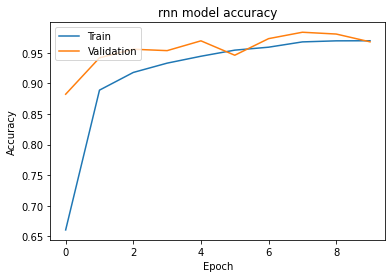

Training cnn model...
Epoch 1/10
383/383 [==============================] - 18s 46ms/step - loss: 0.3712 - accuracy: 0.6471 - val_loss: 0.2023 - val_accuracy: 0.8411
Epoch 2/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1464 - accuracy: 0.8937 - val_loss: 0.1244 - val_accuracy: 0.9057
Epoch 3/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1011 - accuracy: 0.9304 - val_loss: 0.0861 - val_accuracy: 0.9308
Epoch 4/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0754 - accuracy: 0.9482 - val_loss: 0.0457 - val_accuracy: 0.9710
Epoch 5/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0582 - accuracy: 0.9614 - val_loss: 0.0406 - val_accuracy: 0.9762
Epoch 6/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0449 - accuracy: 0.9703 - val_loss: 0.0259 - val_accuracy: 0.9840
Epoch 7/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0358 - accuracy: 0.9775 - val_loss: 

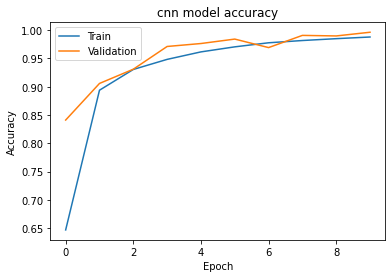

Training lstm model...
Epoch 1/10


2023-03-26 17:19:32.162359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:32.163983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:32.165305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.7022

2023-03-26 17:19:56.518129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:56.519589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:56.520773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 26s 63ms/step - loss: 0.3248 - accuracy: 0.7022 - val_loss: 0.1346 - val_accuracy: 0.9083
Epoch 2/10
383/383 [==============================] - 24s 63ms/step - loss: 0.1446 - accuracy: 0.8960 - val_loss: 0.0913 - val_accuracy: 0.9360
Epoch 3/10
383/383 [==============================] - 25s 64ms/step - loss: 0.1151 - accuracy: 0.9154 - val_loss: 0.0877 - val_accuracy: 0.9406
Epoch 4/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0932 - accuracy: 0.9363 - val_loss: 0.0849 - val_accuracy: 0.9373
Epoch 5/10
383/383 [==============================] - 24s 64ms/step - loss: 0.0803 - accuracy: 0.9449 - val_loss: 0.0447 - val_accuracy: 0.9700
Epoch 6/10
383/383 [==============================] - 25s 66ms/step - loss: 0.0707 - accuracy: 0.9528 - val_loss: 0.0496 - val_accuracy: 0.9687
Epoch 7/10
383/383 [==============================] - 25s 65ms/step - loss: 0.0630 - accuracy: 0.9580 - val_loss: 0.0503 - val_accuracy: 0.9726
Epo

2023-03-26 17:23:41.658377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:41.659456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:41.660408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
lstm model confusion matrix:
[[446  16  31   8]
 [ 19 717  76  11]
 [ 39  46 879  10]
 [  2   5  10 302]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       501
           1       0.91      0.87      0.89       823
           2       0.88      0.90      0.89       974
           3       0.91      0.95      0.93       319

    accuracy                           0.90      2617
   macro avg       0.90      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

lstm model accuracy: 0.8957
lstm model precision: 0.8977
lstm model recall: 0.9026


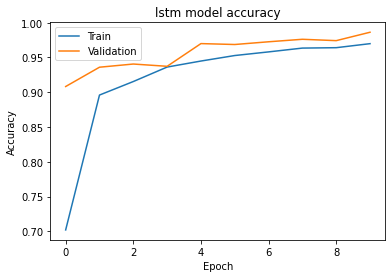

Training bilstm model...
Epoch 1/10


2023-03-26 17:23:43.031252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:43.032503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:43.033485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.7234

2023-03-26 17:24:13.271876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:24:13.273228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:24:13.274451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3104 - accuracy: 0.7234 - val_loss: 0.1424 - val_accuracy: 0.9164
Epoch 2/10
383/383 [==============================] - 31s 80ms/step - loss: 0.1422 - accuracy: 0.8963 - val_loss: 0.0577 - val_accuracy: 0.9615
Epoch 3/10
383/383 [==============================] - 31s 81ms/step - loss: 0.1098 - accuracy: 0.9214 - val_loss: 0.0656 - val_accuracy: 0.9586
Epoch 4/10
383/383 [==============================] - 30s 79ms/step - loss: 0.0932 - accuracy: 0.9336 - val_loss: 0.0603 - val_accuracy: 0.9579
Epoch 5/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0809 - accuracy: 0.9447 - val_loss: 0.0465 - val_accuracy: 0.9749
Epoch 6/10
383/383 [==============================] - 30s 78ms/step - loss: 0.0698 - accuracy: 0.9525 - val_loss: 0.0561 - val_accuracy: 0.9664
Epoch 7/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0621 - accuracy: 0.9579 - val_loss: 0.0513 - val_accuracy: 0.9680
Epo

2023-03-26 17:28:45.427276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:28:45.428777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:28:45.429794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[443  14  40   4]
 [ 19 738  62   4]
 [ 37  62 872   3]
 [  4   6  12 297]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       501
           1       0.90      0.90      0.90       823
           2       0.88      0.90      0.89       974
           3       0.96      0.93      0.95       319

    accuracy                           0.90      2617
   macro avg       0.91      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

bilstm model accuracy: 0.8980
bilstm model precision: 0.9073
bilstm model recall: 0.9018


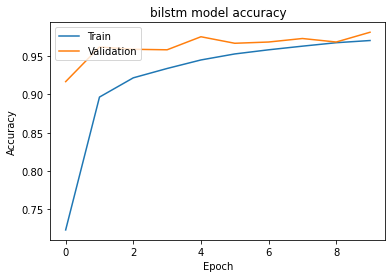

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  


In [7]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'max_seq_length': [50, 100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Epoch 1/5


/tmp/ipykernel_8207/2804649030.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
10/32 [========>.....................] - ETA: 0s - loss: 0.6298 - accuracy: 0.3938

KeyboardInterrupt: 

In [5]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


/tmp/ipykernel_16058/2702622369.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 25ms/step - loss: 0.5831 - accuracy: 0.3620
Epoch 2/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4976 - accuracy: 0.3970
Epoch 3/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4491 - accuracy: 0.4940
Epoch 4/5
32/32 [==============================] - 1s 25ms/step - loss: 0.3527 - accuracy: 0.6500
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 1.1046 - accuracy: 0.0220
Epoch 1/5
32/32 [==============================] - 2s 26ms/step - loss: 0.5964 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5180 - accuracy: 0.4250
Epoch 3/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4963 - accuracy: 0.5180
Epoch 4/5
32/32 [==============================] - 1s 27ms/step - loss: 0.4383 - accuracy: 0.6310
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.0820
Epoch 1/5
32/32 [===============

In [9]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_8598/3319202629.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-29 19:25:29.130409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:29.131488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


2023-03-29 19:25:29.345824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:29.347027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:29.347992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 61ms/step - loss: 0.5676 - accuracy: 0.3660
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4713 - accuracy: 0.4520
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.3742 - accuracy: 0.6560
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2404 - accuracy: 0.8150
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 1.9114 - accuracy: 0.0000e+00

2023-03-29 19:25:40.838413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:40.839666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:40.840835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 11ms/step - loss: 1.5158 - accuracy: 0.1760
Epoch 1/5


2023-03-29 19:25:41.290315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:41.291898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:41.293084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 61ms/step - loss: 0.5907 - accuracy: 0.3860
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4997 - accuracy: 0.5310
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3882 - accuracy: 0.6950
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2876 - accuracy: 0.7440
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5981 - accuracy: 0.3125

2023-03-29 19:25:52.563377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:52.564650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:52.565645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.6240 - accuracy: 0.3480
Epoch 1/5


2023-03-29 19:25:52.995743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:25:52.996851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:25:52.997866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 61ms/step - loss: 0.5718 - accuracy: 0.3540
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4769 - accuracy: 0.4410
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.3707 - accuracy: 0.6790
Epoch 4/5
32/32 [==============================] - 2s 61ms/step - loss: 0.2450 - accuracy: 0.8020
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3563 - accuracy: 0.6875

2023-03-29 19:26:04.269682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:04.270834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:04.271795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5328 - accuracy: 0.1700
Epoch 1/5


2023-03-29 19:26:04.716718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:04.718130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:04.719146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 111ms/step - loss: 0.5555 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 4s 110ms/step - loss: 0.4831 - accuracy: 0.4050
Epoch 3/5
32/32 [==============================] - 4s 110ms/step - loss: 0.4203 - accuracy: 0.5880
Epoch 4/5
32/32 [==============================] - 4s 110ms/step - loss: 0.2701 - accuracy: 0.7700
Epoch 5/5
 7/16 [============>.................] - ETA: 0s - loss: 1.9409 - accuracy: 0.0000e+00

2023-03-29 19:26:23.893485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:23.894912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:23.895855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5729 - accuracy: 0.1320
Epoch 1/5


2023-03-29 19:26:24.338004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:24.339423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:24.340571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 114ms/step - loss: 0.5740 - accuracy: 0.3960
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.5125 - accuracy: 0.4500
Epoch 3/5
32/32 [==============================] - 4s 113ms/step - loss: 0.4059 - accuracy: 0.7030
Epoch 4/5
32/32 [==============================] - 4s 113ms/step - loss: 0.2876 - accuracy: 0.7470
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.6544 - accuracy: 0.2188

2023-03-29 19:26:44.067095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:44.068485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:44.069772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.6504 - accuracy: 0.2880
Epoch 1/5


2023-03-29 19:26:44.515475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:26:44.516796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:26:44.517886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 113ms/step - loss: 0.5690 - accuracy: 0.3590
Epoch 2/5
32/32 [==============================] - 4s 113ms/step - loss: 0.4784 - accuracy: 0.4230
Epoch 3/5
32/32 [==============================] - 4s 112ms/step - loss: 0.4089 - accuracy: 0.6430
Epoch 4/5
32/32 [==============================] - 4s 112ms/step - loss: 0.2805 - accuracy: 0.7520
Epoch 5/5
 7/16 [============>.................] - ETA: 0s - loss: 1.1038 - accuracy: 0.3304

2023-03-29 19:27:04.085375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:04.086809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:04.087731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5565 - accuracy: 0.1480
Epoch 1/5


2023-03-29 19:27:04.523347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:04.524518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:04.525612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 85ms/step - loss: 0.5392 - accuracy: 0.3900
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.4766 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 3s 85ms/step - loss: 0.3930 - accuracy: 0.6200
Epoch 4/5
32/32 [==============================] - 3s 85ms/step - loss: 0.2388 - accuracy: 0.8020
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.3306 - accuracy: 0.0000e+00

2023-03-29 19:27:20.222719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:20.223990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:20.225081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.7884 - accuracy: 0.1880
Epoch 1/5


2023-03-29 19:27:20.784433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:20.785613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:20.786810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 85ms/step - loss: 0.5716 - accuracy: 0.3880
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.5068 - accuracy: 0.4820
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4034 - accuracy: 0.6840
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2705 - accuracy: 0.7530
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.6457 - accuracy: 0.3125

2023-03-29 19:27:36.037220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:36.038540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:36.039389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 0.6785 - accuracy: 0.3400
Epoch 1/5


2023-03-29 19:27:36.594234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:36.595582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:36.596450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 86ms/step - loss: 0.5422 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 3s 85ms/step - loss: 0.4321 - accuracy: 0.5600
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3036 - accuracy: 0.7240
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2217 - accuracy: 0.8140
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 0.4751 - accuracy: 0.6172

2023-03-29 19:27:51.867698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:51.868849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:51.869744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.5901 - accuracy: 0.1580
Epoch 1/5


2023-03-29 19:27:52.430946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:27:52.432335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:27:52.433177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5540 - accuracy: 0.3740
Epoch 2/5
32/32 [==============================] - 4s 140ms/step - loss: 0.4894 - accuracy: 0.4020
Epoch 3/5
32/32 [==============================] - 5s 142ms/step - loss: 0.4230 - accuracy: 0.5890
Epoch 4/5
32/32 [==============================] - 5s 142ms/step - loss: 0.2689 - accuracy: 0.7690
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.0855 - accuracy: 0.0000e+00

2023-03-29 19:28:16.543718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:16.544764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:16.545722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.6311 - accuracy: 0.1700
Epoch 1/5


2023-03-29 19:28:17.107690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:17.108954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:17.109899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 140ms/step - loss: 0.5617 - accuracy: 0.4050
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4830 - accuracy: 0.5620
Epoch 3/5
32/32 [==============================] - 4s 139ms/step - loss: 0.3462 - accuracy: 0.7080
Epoch 4/5
32/32 [==============================] - 4s 140ms/step - loss: 0.2443 - accuracy: 0.7710
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5841 - accuracy: 0.4062

2023-03-29 19:28:41.032513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:41.033729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:41.034945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 0.6392 - accuracy: 0.4160
Epoch 1/5


2023-03-29 19:28:41.602852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:28:41.603923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:28:41.604811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 143ms/step - loss: 0.5348 - accuracy: 0.3630
Epoch 2/5
32/32 [==============================] - 5s 143ms/step - loss: 0.4553 - accuracy: 0.4870
Epoch 3/5
32/32 [==============================] - 5s 140ms/step - loss: 0.3385 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 5s 141ms/step - loss: 0.2368 - accuracy: 0.7960
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3392 - accuracy: 0.7188

2023-03-29 19:29:05.759716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:05.761315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:05.762647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.5980 - accuracy: 0.1840
Epoch 1/5


2023-03-29 19:29:06.316705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:06.317863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:06.319076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 62ms/step - loss: 0.5764 - accuracy: 0.3490
Epoch 2/5
32/32 [==============================] - 2s 64ms/step - loss: 0.4887 - accuracy: 0.3870
Epoch 3/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4211 - accuracy: 0.6030
Epoch 4/5
32/32 [==============================] - 2s 62ms/step - loss: 0.2529 - accuracy: 0.8360
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 1.8874 - accuracy: 0.0000e+00

2023-03-29 19:29:18.383864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:18.385279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:18.386586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.4911 - accuracy: 0.1900
Epoch 1/5


2023-03-29 19:29:18.830894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:18.832541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:18.833973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 60ms/step - loss: 0.6013 - accuracy: 0.3590
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.5211 - accuracy: 0.4190
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.4544 - accuracy: 0.6200
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.2766 - accuracy: 0.7820
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.4429 - accuracy: 0.6562

2023-03-29 19:29:30.042832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:30.044422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:30.045608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.5241 - accuracy: 0.4780
Epoch 1/5


2023-03-29 19:29:30.485124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:30.486130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:30.487196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 60ms/step - loss: 0.5754 - accuracy: 0.3870
Epoch 2/5
32/32 [==============================] - 2s 61ms/step - loss: 0.4864 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3992 - accuracy: 0.6540
Epoch 4/5
32/32 [==============================] - 2s 60ms/step - loss: 0.3023 - accuracy: 0.7250
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 1.0082 - accuracy: 0.2344

2023-03-29 19:29:41.685497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:41.686878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:41.687833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5085 - accuracy: 0.0900
Epoch 1/5


2023-03-29 19:29:42.144632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:29:42.145725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:29:42.146665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5711 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.4825 - accuracy: 0.4120
Epoch 3/5
32/32 [==============================] - 4s 111ms/step - loss: 0.4039 - accuracy: 0.6540
Epoch 4/5
32/32 [==============================] - 4s 113ms/step - loss: 0.2419 - accuracy: 0.8490
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 2.2090 - accuracy: 0.0000e+00

2023-03-29 19:30:01.673430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:01.674904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:01.675831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.7272 - accuracy: 0.1840
Epoch 1/5


2023-03-29 19:30:02.122528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:02.124014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:02.125205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5790 - accuracy: 0.4040
Epoch 2/5
32/32 [==============================] - 4s 111ms/step - loss: 0.5020 - accuracy: 0.5070
Epoch 3/5
32/32 [==============================] - 4s 111ms/step - loss: 0.3663 - accuracy: 0.7160
Epoch 4/5
32/32 [==============================] - 4s 110ms/step - loss: 0.2547 - accuracy: 0.7570
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 0.5435 - accuracy: 0.2552

2023-03-29 19:30:21.460508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:21.461924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:21.463151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 0.5719 - accuracy: 0.3960
Epoch 1/5


2023-03-29 19:30:21.907678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:21.908674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:21.909639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 112ms/step - loss: 0.5624 - accuracy: 0.3860
Epoch 2/5
32/32 [==============================] - 4s 114ms/step - loss: 0.4748 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 4s 113ms/step - loss: 0.3794 - accuracy: 0.6720
Epoch 4/5
32/32 [==============================] - 4s 114ms/step - loss: 0.2759 - accuracy: 0.7670
Epoch 5/5
 6/16 [==========>...................] - ETA: 0s - loss: 0.8905 - accuracy: 0.4688

2023-03-29 19:30:43.785020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:43.786411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:43.787570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 0s 10ms/step - loss: 1.5121 - accuracy: 0.1800
Epoch 1/5


2023-03-29 19:30:44.229118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:30:44.230225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:30:44.231239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 88ms/step - loss: 0.5477 - accuracy: 0.3760
Epoch 2/5
32/32 [==============================] - 3s 87ms/step - loss: 0.4812 - accuracy: 0.4150
Epoch 3/5
32/32 [==============================] - 3s 89ms/step - loss: 0.3926 - accuracy: 0.6280
Epoch 4/5
32/32 [==============================] - 3s 87ms/step - loss: 0.2368 - accuracy: 0.8410
Epoch 5/5
 1/16 [>.............................] - ETA: 11s - loss: 2.3610 - accuracy: 0.0000e+00

2023-03-29 19:31:00.290746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:00.292269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:00.293389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.8895 - accuracy: 0.1360
Epoch 1/5


2023-03-29 19:31:00.874452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:00.875917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:00.877234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 85ms/step - loss: 0.5522 - accuracy: 0.4060
Epoch 2/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4966 - accuracy: 0.5010
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3293 - accuracy: 0.7230
Epoch 4/5
32/32 [==============================] - 3s 85ms/step - loss: 0.2057 - accuracy: 0.8180
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.5756 - accuracy: 0.4375

2023-03-29 19:31:16.167663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:16.168735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:16.169665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 0.6289 - accuracy: 0.4300
Epoch 1/5


2023-03-29 19:31:16.731663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:16.733081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:16.734376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 4s 86ms/step - loss: 0.5481 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 3s 86ms/step - loss: 0.4588 - accuracy: 0.4840
Epoch 3/5
32/32 [==============================] - 3s 86ms/step - loss: 0.3398 - accuracy: 0.6870
Epoch 4/5
32/32 [==============================] - 3s 86ms/step - loss: 0.2446 - accuracy: 0.8100
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.4271 - accuracy: 0.5938

2023-03-29 19:31:32.063193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:32.064472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:32.065291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.4718 - accuracy: 0.1500
Epoch 1/5


2023-03-29 19:31:32.628531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:32.629962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:32.630941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5391 - accuracy: 0.3440
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4811 - accuracy: 0.3980
Epoch 3/5
32/32 [==============================] - 5s 146ms/step - loss: 0.4387 - accuracy: 0.5780
Epoch 4/5
32/32 [==============================] - 5s 149ms/step - loss: 0.2926 - accuracy: 0.7820
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 2.4747 - accuracy: 0.0000e+00

2023-03-29 19:31:57.220463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:57.221822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:57.222876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 18ms/step - loss: 1.9468 - accuracy: 0.1680
Epoch 1/5


2023-03-29 19:31:57.788779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:31:57.790186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:31:57.791422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5701 - accuracy: 0.3840
Epoch 2/5
32/32 [==============================] - 5s 141ms/step - loss: 0.4982 - accuracy: 0.5190
Epoch 3/5
32/32 [==============================] - 5s 142ms/step - loss: 0.3413 - accuracy: 0.7310
Epoch 4/5
32/32 [==============================] - 5s 141ms/step - loss: 0.2129 - accuracy: 0.8210
Epoch 5/5
 4/16 [======>.......................] - ETA: 0s - loss: 0.3834 - accuracy: 0.7188

2023-03-29 19:32:21.904357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:21.905466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:21.906372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 0.4919 - accuracy: 0.5140
Epoch 1/5


2023-03-29 19:32:22.465442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:22.466791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:22.467627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 141ms/step - loss: 0.5539 - accuracy: 0.3760
Epoch 2/5
32/32 [==============================] - 4s 139ms/step - loss: 0.4457 - accuracy: 0.5340
Epoch 3/5
32/32 [==============================] - 4s 140ms/step - loss: 0.3153 - accuracy: 0.7090
Epoch 4/5
32/32 [==============================] - 4s 139ms/step - loss: 0.2487 - accuracy: 0.7980
Epoch 5/5
 1/16 [>.............................] - ETA: 4s - loss: 0.3912 - accuracy: 0.6250

2023-03-29 19:32:46.326603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:46.327700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:46.328633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 17ms/step - loss: 1.4394 - accuracy: 0.1540
Epoch 1/5


2023-03-29 19:32:46.898751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 19:32:46.899932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 19:32:46.901147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 8s 142ms/step - loss: 0.5826 - accuracy: 0.3060
Epoch 2/5
47/47 [==============================] - 7s 148ms/step - loss: 0.4529 - accuracy: 0.5693
Epoch 3/5
47/47 [==============================] - 7s 148ms/step - loss: 0.2637 - accuracy: 0.7807
Epoch 4/5
47/47 [==============================] - 7s 143ms/step - loss: 0.2040 - accuracy: 0.8547
Epoch 5/5
47/47 [==============================] - 7s 142ms/step - loss: 0.1448 - accuracy: 0.9033
Best parameters: {'dense_size': 64, 'dropout_rate': 0.3, 'embedding_size': 128, 'lstm_size': 128, 'num_words': 50000}
Best accuracy: 0.2786666651566823


In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

/tmp/ipykernel_8598/1569365333.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-29 20:46:19.128037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:19.129057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conca

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5


2023-03-29 20:46:19.237920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-29 20:46:19.271491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:19.272442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

32/32 [==============================] - 5s 80ms/step - loss: 0.5455 - accuracy: 0.3790
Epoch 2/5
32/32 [==============================] - 2s 74ms/step - loss: 0.4655 - accuracy: 0.4680
Epoch 3/5
32/32 [==============================] - 2s 71ms/step - loss: 0.3303 - accuracy: 0.7130
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1715 - accuracy: 0.8700
Epoch 5/5
32/32 [==============================] - 2s 72ms/step - loss: 0.1064 - accuracy: 0.9260


2023-03-29 20:46:33.932364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:33.933399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:33.934327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.5309 - accuracy: 0.1800
Epoch 1/5


2023-03-29 20:46:34.585323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:34.586714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:34.587564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:46:36.218771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 71ms/step - loss: 0.5783 - accuracy: 0.3910
Epoch 2/5
32/32 [==============================] - 2s 72ms/step - loss: 0.5011 - accuracy: 0.4980
Epoch 3/5
32/32 [==============================] - 2s 72ms/step - loss: 0.3691 - accuracy: 0.7050
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.2581 - accuracy: 0.7650
Epoch 5/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1809 - accuracy: 0.8500


2023-03-29 20:46:48.437982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:48.439175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:48.440016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.6654 - accuracy: 0.3360
Epoch 1/5


2023-03-29 20:46:49.102516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:46:49.103647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:46:49.104663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:46:50.738659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 72ms/step - loss: 0.5398 - accuracy: 0.3800
Epoch 2/5
32/32 [==============================] - 2s 71ms/step - loss: 0.4618 - accuracy: 0.4930
Epoch 3/5
32/32 [==============================] - 2s 71ms/step - loss: 0.3525 - accuracy: 0.6690
Epoch 4/5
32/32 [==============================] - 2s 71ms/step - loss: 0.2590 - accuracy: 0.7770
Epoch 5/5
32/32 [==============================] - 2s 71ms/step - loss: 0.1823 - accuracy: 0.8810


2023-03-29 20:47:02.993597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:02.995053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:02.996302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4906 - accuracy: 0.1760
Epoch 1/5


2023-03-29 20:47:03.654832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:03.655923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:03.656828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:47:05.695451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5407 - accuracy: 0.3650
Epoch 2/5
32/32 [==============================] - 4s 136ms/step - loss: 0.4679 - accuracy: 0.4300
Epoch 3/5
32/32 [==============================] - 4s 126ms/step - loss: 0.3721 - accuracy: 0.6600
Epoch 4/5
32/32 [==============================] - 4s 126ms/step - loss: 0.2404 - accuracy: 0.8050
Epoch 5/5
32/32 [==============================] - 4s 126ms/step - loss: 0.1586 - accuracy: 0.8800


2023-03-29 20:47:26.934103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:26.935241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:26.936123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 2.0969 - accuracy: 0.1500


2023-03-29 20:47:27.597489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:27.598965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:27.600066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:47:27.932388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:27.934664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:27.935979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 121ms/step - loss: 0.5692 - accuracy: 0.4070
Epoch 2/5
32/32 [==============================] - 4s 121ms/step - loss: 0.4674 - accuracy: 0.6080
Epoch 3/5
32/32 [==============================] - 4s 121ms/step - loss: 0.3082 - accuracy: 0.7410
Epoch 4/5
32/32 [==============================] - 4s 121ms/step - loss: 0.2101 - accuracy: 0.8220
Epoch 5/5
32/32 [==============================] - 4s 121ms/step - loss: 0.1670 - accuracy: 0.8400


2023-03-29 20:47:49.485806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:49.487218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:49.488222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.5480 - accuracy: 0.4720
Epoch 1/5


2023-03-29 20:47:50.147031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:47:50.148501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:47:50.149763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:47:51.825867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 121ms/step - loss: 0.5577 - accuracy: 0.3320
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4752 - accuracy: 0.4430
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3532 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 4s 122ms/step - loss: 0.2636 - accuracy: 0.7710
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.1959 - accuracy: 0.8680


2023-03-29 20:48:12.342664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:12.343982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:12.344961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.6006 - accuracy: 0.1680


2023-03-29 20:48:12.997709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:12.999108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:13.000095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:48:13.340151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:13.341683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:13.342630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 121ms/step - loss: 0.5329 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 4s 121ms/step - loss: 0.4641 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 4s 122ms/step - loss: 0.3429 - accuracy: 0.6760
Epoch 4/5
32/32 [==============================] - 4s 121ms/step - loss: 0.2099 - accuracy: 0.8440
Epoch 5/5
32/32 [==============================] - 4s 121ms/step - loss: 0.1259 - accuracy: 0.9110


2023-03-29 20:48:35.319252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:35.320638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:35.321921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.6341 - accuracy: 0.1740
Epoch 1/5


2023-03-29 20:48:36.194962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:36.196126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:36.197160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:48:37.849573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5589 - accuracy: 0.3980
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4931 - accuracy: 0.4800
Epoch 3/5
32/32 [==============================] - 4s 134ms/step - loss: 0.3136 - accuracy: 0.7370
Epoch 4/5
32/32 [==============================] - 4s 129ms/step - loss: 0.1935 - accuracy: 0.8270
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1618 - accuracy: 0.8620


2023-03-29 20:48:58.941026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:58.942277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:58.943210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 0.6170 - accuracy: 0.4140
Epoch 1/5


2023-03-29 20:48:59.791386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:48:59.792494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:48:59.793506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:49:01.447214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5280 - accuracy: 0.3730
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4440 - accuracy: 0.5290
Epoch 3/5
32/32 [==============================] - 4s 123ms/step - loss: 0.3247 - accuracy: 0.7120
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2292 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 4s 123ms/step - loss: 0.1786 - accuracy: 0.8690


2023-03-29 20:49:21.954819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:21.955826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:21.956845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.6545 - accuracy: 0.1280


2023-03-29 20:49:22.816956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:22.818092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:22.819004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:49:23.152422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:23.153548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:23.154499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 8s 178ms/step - loss: 0.5398 - accuracy: 0.3440
Epoch 2/5
32/32 [==============================] - 6s 179ms/step - loss: 0.4802 - accuracy: 0.3950
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4035 - accuracy: 0.6080
Epoch 4/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2288 - accuracy: 0.8220
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1316 - accuracy: 0.9090


2023-03-29 20:49:53.771937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:53.773346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:53.774356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.5784 - accuracy: 0.1980
Epoch 1/5


2023-03-29 20:49:54.623510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:49:54.624682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:49:54.625687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:49:56.742739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 173ms/step - loss: 0.5599 - accuracy: 0.3950
Epoch 2/5
32/32 [==============================] - 6s 173ms/step - loss: 0.4618 - accuracy: 0.5990
Epoch 3/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2954 - accuracy: 0.7310
Epoch 4/5
32/32 [==============================] - 6s 174ms/step - loss: 0.1931 - accuracy: 0.8390
Epoch 5/5
32/32 [==============================] - 6s 174ms/step - loss: 0.1814 - accuracy: 0.8300


2023-03-29 20:50:25.501700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:25.502978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:25.504186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 0.4737 - accuracy: 0.5180
Epoch 1/5


2023-03-29 20:50:26.354624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:26.355913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:26.356863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:50:27.996317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 175ms/step - loss: 0.5265 - accuracy: 0.3790
Epoch 2/5
32/32 [==============================] - 6s 174ms/step - loss: 0.4377 - accuracy: 0.5490
Epoch 3/5
32/32 [==============================] - 6s 174ms/step - loss: 0.3001 - accuracy: 0.7180
Epoch 4/5
32/32 [==============================] - 6s 177ms/step - loss: 0.2341 - accuracy: 0.8060
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1829 - accuracy: 0.8750


2023-03-29 20:50:56.989453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:56.990685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:56.991811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 1.7065 - accuracy: 0.1840
Epoch 1/5


2023-03-29 20:50:57.861318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:50:57.862389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:50:57.863298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:50:59.496918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 4s 72ms/step - loss: 0.5561 - accuracy: 0.3680
Epoch 2/5
32/32 [==============================] - 2s 72ms/step - loss: 0.4808 - accuracy: 0.4290
Epoch 3/5
32/32 [==============================] - 2s 72ms/step - loss: 0.3809 - accuracy: 0.6100
Epoch 4/5
32/32 [==============================] - 2s 72ms/step - loss: 0.2696 - accuracy: 0.7340
Epoch 5/5
32/32 [==============================] - 2s 74ms/step - loss: 0.2143 - accuracy: 0.8100


2023-03-29 20:51:11.886575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:11.887904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:11.889032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4270 - accuracy: 0.1980


2023-03-29 20:51:12.547660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:12.549203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:12.550288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:51:12.899315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:12.900483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:12.901577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 5s 84ms/step - loss: 0.5922 - accuracy: 0.3380
Epoch 2/5
32/32 [==============================] - 3s 82ms/step - loss: 0.5130 - accuracy: 0.4530
Epoch 3/5
32/32 [==============================] - 2s 76ms/step - loss: 0.3876 - accuracy: 0.6960
Epoch 4/5
32/32 [==============================] - 2s 75ms/step - loss: 0.2564 - accuracy: 0.7860
Epoch 5/5
32/32 [==============================] - 2s 73ms/step - loss: 0.1811 - accuracy: 0.8560


2023-03-29 20:51:28.128806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:28.129850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:28.130908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.6522 - accuracy: 0.3440
Epoch 1/5


2023-03-29 20:51:28.787311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:28.788508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:28.789514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:51:30.496597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 5s 74ms/step - loss: 0.5452 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 2s 73ms/step - loss: 0.4498 - accuracy: 0.5060
Epoch 3/5
32/32 [==============================] - 2s 74ms/step - loss: 0.3284 - accuracy: 0.6920
Epoch 4/5
32/32 [==============================] - 2s 73ms/step - loss: 0.2706 - accuracy: 0.7670
Epoch 5/5
32/32 [==============================] - 2s 74ms/step - loss: 0.2030 - accuracy: 0.8560


2023-03-29 20:51:43.130461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:43.131609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:43.132539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.6635 - accuracy: 0.1660
Epoch 1/5


2023-03-29 20:51:43.805613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:51:43.806695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:51:43.807654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:51:45.463867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5579 - accuracy: 0.3740
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4833 - accuracy: 0.4060
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3920 - accuracy: 0.6250
Epoch 4/5
32/32 [==============================] - 4s 123ms/step - loss: 0.2804 - accuracy: 0.7240
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2190 - accuracy: 0.8110


2023-03-29 20:52:06.089706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:06.090779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:06.091853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.4756 - accuracy: 0.1620
Epoch 1/5


2023-03-29 20:52:06.751978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:06.753246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:06.754195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:52:08.417764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 123ms/step - loss: 0.5727 - accuracy: 0.3870
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4962 - accuracy: 0.5330
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3496 - accuracy: 0.7220
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2440 - accuracy: 0.7850
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1814 - accuracy: 0.8390


2023-03-29 20:52:29.472678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:29.473776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:29.474700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 0.5779 - accuracy: 0.3900


2023-03-29 20:52:30.153989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:30.155155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:30.156335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:52:30.500137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:30.501189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:30.502525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 6s 122ms/step - loss: 0.5380 - accuracy: 0.3920
Epoch 2/5
32/32 [==============================] - 4s 122ms/step - loss: 0.4565 - accuracy: 0.5090
Epoch 3/5
32/32 [==============================] - 4s 122ms/step - loss: 0.3194 - accuracy: 0.7120
Epoch 4/5
32/32 [==============================] - 4s 122ms/step - loss: 0.2394 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 4s 124ms/step - loss: 0.1794 - accuracy: 0.8860


2023-03-29 20:52:52.307899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:52.309023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:52.310334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 12ms/step - loss: 1.5746 - accuracy: 0.1620
Epoch 1/5


2023-03-29 20:52:52.966899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:52:52.968037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:52:52.968983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:52:54.632429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 122ms/step - loss: 0.5388 - accuracy: 0.3610
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4752 - accuracy: 0.4260
Epoch 3/5
32/32 [==============================] - 4s 123ms/step - loss: 0.3660 - accuracy: 0.6710
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2404 - accuracy: 0.8120
Epoch 5/5
32/32 [==============================] - 4s 123ms/step - loss: 0.1358 - accuracy: 0.9030


2023-03-29 20:53:15.192604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:15.193737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:15.194618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.9960 - accuracy: 0.1840
Epoch 1/5


2023-03-29 20:53:16.048564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:16.049834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:16.050848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:53:17.707641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 6s 124ms/step - loss: 0.5598 - accuracy: 0.4100
Epoch 2/5
32/32 [==============================] - 4s 124ms/step - loss: 0.4713 - accuracy: 0.5700
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2924 - accuracy: 0.7510
Epoch 4/5
32/32 [==============================] - 4s 124ms/step - loss: 0.2155 - accuracy: 0.8150
Epoch 5/5
32/32 [==============================] - 4s 125ms/step - loss: 0.1648 - accuracy: 0.8490


2023-03-29 20:53:38.426027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:38.427147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:38.428532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 26ms/step - loss: 0.5748 - accuracy: 0.4440


2023-03-29 20:53:39.309823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:39.311205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:39.312360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:53:39.673079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:53:39.674765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:53:39.676095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 7s 129ms/step - loss: 0.5316 - accuracy: 0.4000
Epoch 2/5
32/32 [==============================] - 4s 123ms/step - loss: 0.4152 - accuracy: 0.5870
Epoch 3/5
32/32 [==============================] - 4s 124ms/step - loss: 0.3373 - accuracy: 0.6890
Epoch 4/5
32/32 [==============================] - 4s 130ms/step - loss: 0.2494 - accuracy: 0.7810
Epoch 5/5
32/32 [==============================] - 4s 129ms/step - loss: 0.1920 - accuracy: 0.8540


2023-03-29 20:54:02.795875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:02.796935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:02.797967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 1.6321 - accuracy: 0.1780


2023-03-29 20:54:03.714607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:03.715783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:03.716804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-03-29 20:54:04.075389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:04.076535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:04.077731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 8s 179ms/step - loss: 0.5285 - accuracy: 0.3670
Epoch 2/5
32/32 [==============================] - 6s 176ms/step - loss: 0.4794 - accuracy: 0.4140
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4239 - accuracy: 0.5740
Epoch 4/5
32/32 [==============================] - 6s 178ms/step - loss: 0.2402 - accuracy: 0.8200
Epoch 5/5
32/32 [==============================] - 6s 177ms/step - loss: 0.1706 - accuracy: 0.8790


2023-03-29 20:54:34.751787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:34.752886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:34.753925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.5412 - accuracy: 0.1680
Epoch 1/5


2023-03-29 20:54:35.613724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:54:35.615172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:54:35.616363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:54:37.278840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 178ms/step - loss: 0.5536 - accuracy: 0.3990
Epoch 2/5
32/32 [==============================] - 6s 178ms/step - loss: 0.4824 - accuracy: 0.5500
Epoch 3/5
32/32 [==============================] - 6s 180ms/step - loss: 0.3060 - accuracy: 0.7330
Epoch 4/5
32/32 [==============================] - 6s 179ms/step - loss: 0.2157 - accuracy: 0.8160
Epoch 5/5
32/32 [==============================] - 6s 178ms/step - loss: 0.1740 - accuracy: 0.8470


2023-03-29 20:55:06.656915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:06.658030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:06.658952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 25ms/step - loss: 0.6442 - accuracy: 0.3360
Epoch 1/5


2023-03-29 20:55:07.528041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:07.529501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:07.530365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:55:09.608134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


32/32 [==============================] - 8s 176ms/step - loss: 0.5469 - accuracy: 0.3620
Epoch 2/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4714 - accuracy: 0.4670
Epoch 3/5
32/32 [==============================] - 6s 177ms/step - loss: 0.3398 - accuracy: 0.7060
Epoch 4/5
32/32 [==============================] - 6s 191ms/step - loss: 0.2430 - accuracy: 0.7950
Epoch 5/5
32/32 [==============================] - 6s 184ms/step - loss: 0.1793 - accuracy: 0.8740


2023-03-29 20:55:39.437502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:39.439068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:39.440319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 24ms/step - loss: 1.4619 - accuracy: 0.1820
Epoch 1/5


2023-03-29 20:55:40.314745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:55:40.315995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:55:40.316868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-03-29 20:55:41.976443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


47/47 [==============================] - 10s 176ms/step - loss: 0.5780 - accuracy: 0.3020
Epoch 2/5
47/47 [==============================] - 8s 176ms/step - loss: 0.4214 - accuracy: 0.5880
Epoch 3/5
47/47 [==============================] - 8s 176ms/step - loss: 0.2579 - accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 8s 176ms/step - loss: 0.1776 - accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 8s 176ms/step - loss: 0.1301 - accuracy: 0.9133
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 128, 'lstm_size': 128, 'num_words': 50000}
Best accuracy: 0.3000000019868215


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128, 256],
              'filter_size': [16, 32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [32, 64, 128],
              'dropout_rate': [0.2, 0.3, 0.4]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid to search over

param_grid = {'num_words': [50000],
              'embedding_size': [64,128],
              'filter_size': [32],
              'kernel_size': [3,5],
              'pool_size': [2,3],
              'dense_size': [64,128],
              'dropout_rate': [0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/5


/tmp/ipykernel_8598/654584404.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 54ms/step - loss: 0.6458 - accuracy: 0.2840
Epoch 2/5
32/32 [==============================] - 2s 56ms/step - loss: 0.5050 - accuracy: 0.3810
Epoch 3/5
32/32 [==============================] - 2s 54ms/step - loss: 0.4848 - accuracy: 0.3880
Epoch 4/5
32/32 [==============================] - 2s 55ms/step - loss: 0.4347 - accuracy: 0.5510
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 1.2550 - accuracy: 0.1460
Epoch 1/5
32/32 [==============================] - 3s 60ms/step - loss: 0.6251 - accuracy: 0.3230
Epoch 2/5
32/32 [==============================] - 2s 69ms/step - loss: 0.5360 - accuracy: 0.3670
Epoch 3/5
32/32 [==============================] - 2s 70ms/step - loss: 0.5284 - accuracy: 0.4000
Epoch 4/5
32/32 [==============================] - 2s 69ms/step - loss: 0.4944 - accuracy: 0.5640
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 0.7424 - accuracy: 0.0000e+00
Epoch 1/5
32/32 [===========

32/32 [==============================] - 3s 98ms/step - loss: 0.4834 - accuracy: 0.4220
Epoch 3/5
32/32 [==============================] - 3s 97ms/step - loss: 0.3975 - accuracy: 0.6110
Epoch 4/5
32/32 [==============================] - 3s 97ms/step - loss: 0.2914 - accuracy: 0.7480
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.5519 - accuracy: 0.1600
Epoch 1/5
32/32 [==============================] - 4s 97ms/step - loss: 0.6020 - accuracy: 0.3570
Epoch 2/5
32/32 [==============================] - 3s 97ms/step - loss: 0.5029 - accuracy: 0.3540
Epoch 3/5
32/32 [==============================] - 3s 97ms/step - loss: 0.4884 - accuracy: 0.4020
Epoch 4/5
32/32 [==============================] - 3s 97ms/step - loss: 0.4648 - accuracy: 0.4420
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.2718 - accuracy: 0.1440
Epoch 1/5
32/32 [==============================] - 4s 97ms/step - loss: 0.6048 - accuracy: 0.3560
Epoch 2/5
32/32 [===============

32/32 [==============================] - 2s 47ms/step - loss: 0.5271 - accuracy: 0.3900
Epoch 3/5
32/32 [==============================] - 2s 47ms/step - loss: 0.5215 - accuracy: 0.3640
Epoch 4/5
32/32 [==============================] - 2s 47ms/step - loss: 0.5043 - accuracy: 0.4340
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.1280
Epoch 1/5
32/32 [==============================] - 2s 47ms/step - loss: 0.6118 - accuracy: 0.3560
Epoch 2/5
32/32 [==============================] - 2s 47ms/step - loss: 0.4901 - accuracy: 0.3960
Epoch 3/5
32/32 [==============================] - 2s 47ms/step - loss: 0.4620 - accuracy: 0.4640
Epoch 4/5
32/32 [==============================] - 2s 48ms/step - loss: 0.3977 - accuracy: 0.5960
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 1.4497 - accuracy: 0.0020
Epoch 1/5
32/32 [==============================] - 2s 49ms/step - loss: 0.5825 - accuracy: 0.3660
Epoch 2/5
32/32 [===============

32/32 [==============================] - 3s 102ms/step - loss: 0.4872 - accuracy: 0.3930
Epoch 3/5
32/32 [==============================] - 3s 102ms/step - loss: 0.4608 - accuracy: 0.4650
Epoch 4/5
32/32 [==============================] - 3s 102ms/step - loss: 0.3348 - accuracy: 0.6820
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.4883 - accuracy: 0.1400
Epoch 1/5
32/32 [==============================] - 4s 102ms/step - loss: 0.5852 - accuracy: 0.3600
Epoch 2/5
32/32 [==============================] - 3s 102ms/step - loss: 0.5237 - accuracy: 0.3920
Epoch 3/5
32/32 [==============================] - 3s 102ms/step - loss: 0.4548 - accuracy: 0.6170
Epoch 4/5
32/32 [==============================] - 3s 103ms/step - loss: 0.2762 - accuracy: 0.7610
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.4280
Epoch 1/5
32/32 [==============================] - 4s 101ms/step - loss: 0.5811 - accuracy: 0.3630
Epoch 2/5
32/32 [=======

In [ ]:
num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64

In [16]:
X_train_resampled

array([[  0,   0,   0, ..., 409,  25,  43],
       [  0,   0,   0, ..., 428,  56,   1],
       [  0,   0,   0, ...,  37,   1, 247],
       ...,
       [  0,   0,   0, ..., 824,  61,  20],
       [  0,   0,   0, ...,  20,  68,  64],
       [  0,   0,   0, ...,   0,  10, 211]], dtype=int32)

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

In [17]:
df=df[:4000]

2023-03-29 20:36:52.509794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:36:52.510972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:36:52.511962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-29 20:36:52.791447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-29 20:36:52.825525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:36:52.826617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

38/38 [==============================] - 3s 47ms/step - loss: 0.5512 - accuracy: 0.3342 - val_loss: 0.9062 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.4765 - accuracy: 0.5458 - val_loss: 0.9168 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 2s 40ms/step - loss: 0.3987 - accuracy: 0.6483 - val_loss: 0.9131 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 42ms/step - loss: 0.3067 - accuracy: 0.7583 - val_loss: 0.7156 - val_accuracy: 0.1200
Epoch 5/10
38/38 [==============================] - 2s 41ms/step - loss: 0.2140 - accuracy: 0.8600 - val_loss: 0.6666 - val_accuracy: 0.3400
Epoch 6/10
38/38 [==============================] - 2s 41ms/step - loss: 0.1422 - accuracy: 0.9183 - val_loss: 0.5752 - val_accuracy: 0.5467
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0962 - accuracy: 0.9517 - val_loss: 0.5655 - val_accuracy: 0.5967
Epoch 8/10
3

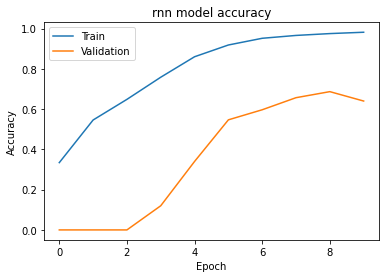

Training cnn model...
Epoch 1/10
38/38 [==============================] - 3s 58ms/step - loss: 0.6050 - accuracy: 0.3050 - val_loss: 0.8248 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 44ms/step - loss: 0.5299 - accuracy: 0.3225 - val_loss: 0.9113 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 2s 44ms/step - loss: 0.4995 - accuracy: 0.5067 - val_loss: 1.0261 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 45ms/step - loss: 0.3977 - accuracy: 0.6717 - val_loss: 0.9903 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 2s 45ms/step - loss: 0.2930 - accuracy: 0.7900 - val_loss: 0.9656 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 2s 45ms/step - loss: 0.2191 - accuracy: 0.8533 - val_loss: 0.9845 - val_accuracy: 0.0000e+00
Epoch 7/10
38/38 [==============================] - 2s 45ms/step - loss: 0.1613 - accuracy: 0.8883 - val_los

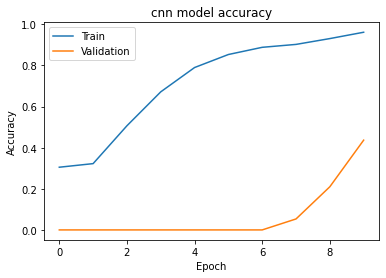

Training lstm model...
Epoch 1/10


2023-03-29 20:37:28.429407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:28.430604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:28.431592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.3233

2023-03-29 20:37:32.114446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:32.115576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:32.116518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 4s 71ms/step - loss: 0.5790 - accuracy: 0.3233 - val_loss: 0.9367 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 3s 66ms/step - loss: 0.4871 - accuracy: 0.4750 - val_loss: 0.8135 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 3s 67ms/step - loss: 0.3704 - accuracy: 0.6750 - val_loss: 0.8176 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 3s 69ms/step - loss: 0.2791 - accuracy: 0.7767 - val_loss: 0.8664 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 3s 68ms/step - loss: 0.2123 - accuracy: 0.8433 - val_loss: 0.7985 - val_accuracy: 0.1400
Epoch 6/10
38/38 [==============================] - 3s 73ms/step - loss: 0.1523 - accuracy: 0.8992 - val_loss: 0.5871 - val_accuracy: 0.4700
Epoch 7/10
38/38 [==============================] - 3s 66ms/step - loss: 0.1111 - accuracy: 0.9350 - val_loss: 0.5080 - val_accuracy: 0.6167
Epoch 8/

2023-03-29 20:37:55.349056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:55.350297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:55.351314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 10ms/step
lstm model confusion matrix:
[[125   5   8   1]
 [ 21 193  35   0]
 [ 27  41 229   5]
 [  9   9   9  83]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       139
           1       0.78      0.78      0.78       249
           2       0.81      0.76      0.79       302
           3       0.93      0.75      0.83       110

    accuracy                           0.79       800
   macro avg       0.80      0.80      0.79       800
weighted avg       0.80      0.79      0.79       800

lstm model accuracy: 0.7875
lstm model precision: 0.8031
lstm model recall: 0.7968


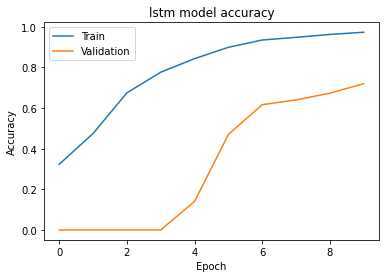

Training bilstm model...
Epoch 1/10


2023-03-29 20:37:55.952344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:37:55.953589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:37:55.954642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.3175

2023-03-29 20:38:00.785151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:38:00.786540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:38:00.787526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 5s 86ms/step - loss: 0.5707 - accuracy: 0.3175 - val_loss: 1.0230 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 3s 74ms/step - loss: 0.4923 - accuracy: 0.5067 - val_loss: 0.9546 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 3s 74ms/step - loss: 0.3705 - accuracy: 0.6808 - val_loss: 0.9307 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 3s 75ms/step - loss: 0.2758 - accuracy: 0.7775 - val_loss: 0.9009 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 3s 74ms/step - loss: 0.2165 - accuracy: 0.8442 - val_loss: 0.9520 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 3s 74ms/step - loss: 0.1673 - accuracy: 0.8692 - val_loss: 0.9556 - val_accuracy: 0.0500
Epoch 7/10
38/38 [==============================] - 3s 74ms/step - loss: 0.1267 - accuracy: 0.9167 - val_loss: 0.6480 - val_accuracy: 0.3633
Epoc

2023-03-29 20:38:26.754599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 20:38:26.755669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 20:38:26.756630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[114   9  14   2]
 [ 11 199  39   0]
 [ 13  37 251   1]
 [  8  17  11  74]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       139
           1       0.76      0.80      0.78       249
           2       0.80      0.83      0.81       302
           3       0.96      0.67      0.79       110

    accuracy                           0.80       800
   macro avg       0.82      0.78      0.80       800
weighted avg       0.81      0.80      0.80       800

bilstm model accuracy: 0.7975
bilstm model precision: 0.8246
bilstm model recall: 0.7808


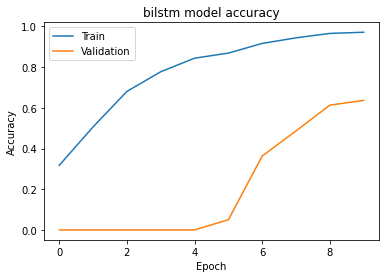

In [18]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  


2023-03-29 21:31:38.861192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:31:38.862307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:31:38.863245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10
383/383 [==============================] - 16s 40ms/step - loss: 0.3179 - accuracy: 0.7131 - val_loss: 0.1227 - val_accuracy: 0.9223
Epoch 2/10
383/383 [==============================] - 15s 40ms/step - loss: 0.1450 - accuracy: 0.8915 - val_loss: 0.0447 - val_accuracy: 0.9700
Epoch 3/10
383/383 [==============================] - 15s 40ms/step - loss: 0.1074 - accuracy: 0.9205 - val_loss: 0.0763 - val_accuracy: 0.9458
Epoch 4/10
383/383 [==============================] - 15s 40ms/step - loss: 0.0858 - accuracy: 0.9388 - val_loss: 0.0491 - val_accuracy: 0.9716
Epoch 5/10
383/383 [==============================] - 15s 40ms/step - loss: 0.0693 - accuracy: 0.9511 - val_loss: 0.0424 - val_accuracy: 0.9696
Epoch 6/10
383/383 [==============================] - 15s 40ms/step - loss: 0.0619 - accuracy: 0.9560 - val_loss: 0.0244 - val_accuracy: 0.9840
Epoch 7/10
383/383 [==============================] - 15s 40ms/step - loss: 0.0545 - accuracy: 0.9617 - val_loss: 

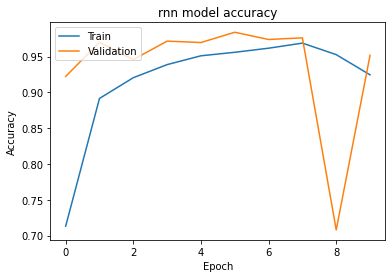

Training cnn model...
Epoch 1/10
383/383 [==============================] - 41s 107ms/step - loss: 0.3434 - accuracy: 0.6644 - val_loss: 0.1231 - val_accuracy: 0.9063
Epoch 2/10
383/383 [==============================] - 40s 105ms/step - loss: 0.1302 - accuracy: 0.9026 - val_loss: 0.0728 - val_accuracy: 0.9501
Epoch 3/10
383/383 [==============================] - 43s 113ms/step - loss: 0.0870 - accuracy: 0.9387 - val_loss: 0.0706 - val_accuracy: 0.9533
Epoch 4/10
383/383 [==============================] - 41s 108ms/step - loss: 0.0633 - accuracy: 0.9585 - val_loss: 0.0473 - val_accuracy: 0.9661
Epoch 5/10
383/383 [==============================] - 41s 106ms/step - loss: 0.0473 - accuracy: 0.9683 - val_loss: 0.0336 - val_accuracy: 0.9772
Epoch 6/10
383/383 [==============================] - 41s 106ms/step - loss: 0.0350 - accuracy: 0.9784 - val_loss: 0.0258 - val_accuracy: 0.9837
Epoch 7/10
383/383 [==============================] - 41s 107ms/step - loss: 0.0300 - accuracy: 0.9820 - val

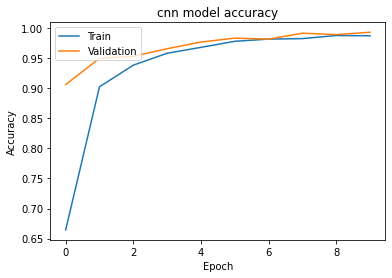

Training lstm model...
Epoch 1/10


2023-03-29 21:41:07.963725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:41:07.965126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:41:07.966173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.7014

2023-03-29 21:42:02.956022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:42:02.957106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:42:02.958011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 57s 144ms/step - loss: 0.3180 - accuracy: 0.7014 - val_loss: 0.1548 - val_accuracy: 0.8858
Epoch 2/10
383/383 [==============================] - 54s 142ms/step - loss: 0.1414 - accuracy: 0.8959 - val_loss: 0.0694 - val_accuracy: 0.9471
Epoch 3/10
383/383 [==============================] - 55s 144ms/step - loss: 0.1077 - accuracy: 0.9221 - val_loss: 0.0629 - val_accuracy: 0.9572
Epoch 4/10
383/383 [==============================] - 60s 157ms/step - loss: 0.0926 - accuracy: 0.9360 - val_loss: 0.0476 - val_accuracy: 0.9670
Epoch 5/10
383/383 [==============================] - 55s 143ms/step - loss: 0.0787 - accuracy: 0.9452 - val_loss: 0.0434 - val_accuracy: 0.9693
Epoch 6/10
383/383 [==============================] - 56s 147ms/step - loss: 0.0727 - accuracy: 0.9505 - val_loss: 0.0459 - val_accuracy: 0.9670
Epoch 7/10
383/383 [==============================] - 56s 145ms/step - loss: 0.0649 - accuracy: 0.9563 - val_loss: 0.0424 - val_accuracy: 0.9

2023-03-29 21:50:29.816813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:50:29.818127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:50:29.819295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 2s 18ms/step
lstm model confusion matrix:
[[454  14  27   6]
 [ 20 723  74   6]
 [ 49  38 882   5]
 [  5   6  13 295]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       501
           1       0.93      0.88      0.90       823
           2       0.89      0.91      0.90       974
           3       0.95      0.92      0.94       319

    accuracy                           0.90      2617
   macro avg       0.90      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

lstm model accuracy: 0.8995
lstm model precision: 0.9042
lstm model recall: 0.9037


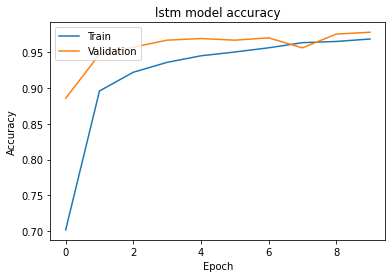

Training bilstm model...
Epoch 1/10


2023-03-29 21:50:31.673128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:50:31.674402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:50:31.675904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.7318

2023-03-29 21:51:41.376179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 21:51:41.377281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 21:51:41.378444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 72s 183ms/step - loss: 0.2950 - accuracy: 0.7318 - val_loss: 0.1399 - val_accuracy: 0.9031
Epoch 2/10
383/383 [==============================] - 70s 182ms/step - loss: 0.1350 - accuracy: 0.9006 - val_loss: 0.0901 - val_accuracy: 0.9354
Epoch 3/10
383/383 [==============================] - 71s 186ms/step - loss: 0.1078 - accuracy: 0.9220 - val_loss: 0.0699 - val_accuracy: 0.9523
Epoch 4/10
383/383 [==============================] - 71s 186ms/step - loss: 0.0888 - accuracy: 0.9370 - val_loss: 0.0601 - val_accuracy: 0.9572
Epoch 5/10
383/383 [==============================] - 71s 185ms/step - loss: 0.0815 - accuracy: 0.9444 - val_loss: 0.0526 - val_accuracy: 0.9661
Epoch 6/10
383/383 [==============================] - 71s 185ms/step - loss: 0.0682 - accuracy: 0.9538 - val_loss: 0.0418 - val_accuracy: 0.9710
Epoch 7/10
383/383 [==============================] - 71s 185ms/step - loss: 0.0627 - accuracy: 0.9576 - val_loss: 0.0416 - val_accuracy: 0.9

2023-03-29 22:02:21.881033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-29 22:02:21.882426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-29 22:02:21.883436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 3s 27ms/step
bilstm model confusion matrix:
[[446  15  32   8]
 [ 24 731  63   5]
 [ 46  60 866   2]
 [  4   5  14 296]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       501
           1       0.90      0.89      0.89       823
           2       0.89      0.89      0.89       974
           3       0.95      0.93      0.94       319

    accuracy                           0.89      2617
   macro avg       0.90      0.90      0.90      2617
weighted avg       0.89      0.89      0.89      2617

bilstm model accuracy: 0.8938
bilstm model precision: 0.8998
bilstm model recall: 0.8989


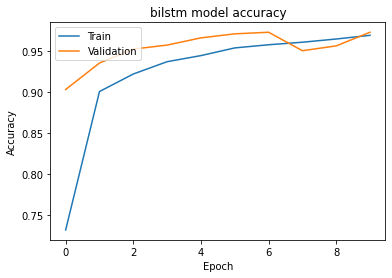

In [24]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  
